# Crime in India

In [1]:
import os
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [8]:
# Define the path to the ZIP file
zip_file_path = 'Crime in India.zip'

# Create a folder to save cleaned datasets
output_folder = 'cleaned_datasets'
os.makedirs(output_folder, exist_ok=True)

# Extract and process all files in the ZIP archive
with zipfile.ZipFile(zip_file_path, 'r') as z:
    file_list = z.namelist()  # List all files in the archive
    print("Files available in the ZIP archive:")
    for file_name in file_list:
        print(file_name)

    # Loop through each file in the archive
    for file_name in file_list:
        # Skip directories
        if file_name.endswith('/'):
            continue
        
        print(f"\nProcessing file: {file_name}")
        try:
            # Extract and load the CSV file
            with z.open(file_name) as file:
                data = pd.read_csv(file, encoding='latin1', low_memory=False)
            
            # Display basic information about the dataset
            print(f"\nDataset Overview: {file_name}")
            print(data.info())
            print(data.head())

            # Handle missing values (basic approach)
            missing_values = data.isnull().sum()
            print("\nMissing Values:")
            print(missing_values)
            
            # Save the dataset for further analysis
            output_file = os.path.join(output_folder, f"{os.path.splitext(file_name)[0]}_cleaned.csv")
            data.to_csv(output_file, index=False)
            print(f"Cleaned dataset saved to: {output_file}")
        
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

print("\nAll datasets have been processed and saved to the 'cleaned_datasets' folder.")

Files available in the ZIP archive:
10_Property_stolen_and_recovered.csv
20_Victims_of_rape.csv
25_Complaints_against_police.csv
28_Trial_of_violent_crimes_by_courts.csv
29_Period_of_trials_by_courts.csv
30_Auto_theft.csv
31_Serious_fraud.csv
32_Murder_victim_age_sex.csv
33_CH_not_murder_victim_age_sex.csv
35_Human_rights_violation_by_police.csv
36_Police_housing.csv
39_Specific_purpose_of_kidnapping_and_abduction.csv
40_01_Custodial_death_person_remanded.csv
40_02_Custodial_death_person_not_remanded.csv
40_03_Custodial_death_during_production.csv
40_04_Custodial_death_during_hospitalization_or_treatment.csv
40_05_Custodial_death_others.csv
42_Cases_under_crime_against_women.csv
43_Arrests_under_crime_against_women.csv
crime/01_District_wise_crimes_committed_IPC_2001_2012.csv
crime/01_District_wise_crimes_committed_IPC_2013.csv
crime/01_District_wise_crimes_committed_IPC_2014.csv
crime/02_01_District_wise_crimes_committed_against_SC_2001_2012.csv
crime/02_01_District_wise_crimes_commit

In [9]:
# Load the dataset
data = pd.read_csv('10_Property_stolen_and_recovered.csv')

# Correct the encoding issue in the column name
data.rename(columns={data.columns[0]: 'Area_Name'}, inplace=True)

# Check for any masked missing values if suspects exist (e.g., '-')
# data.replace('-', pd.NA, inplace=True)

# Optionally, check for and handle outliers in numerical columns
# For example, replace values that are beyond a reasonable range
# max_value = data['Value_of_Property_Stolen'].quantile(0.99)
# data.loc[data['Value_of_Property_Stolen'] > max_value, 'Value_of_Property_Stolen'] = max_value

# Save the cleaned data
data.to_csv('cleaned_10_Property_stolen_and_recovered.csv', index=False)


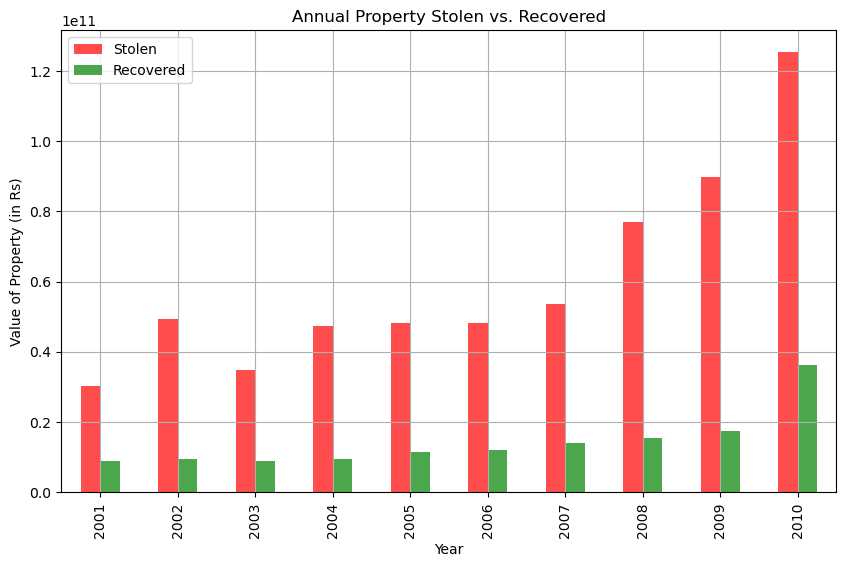

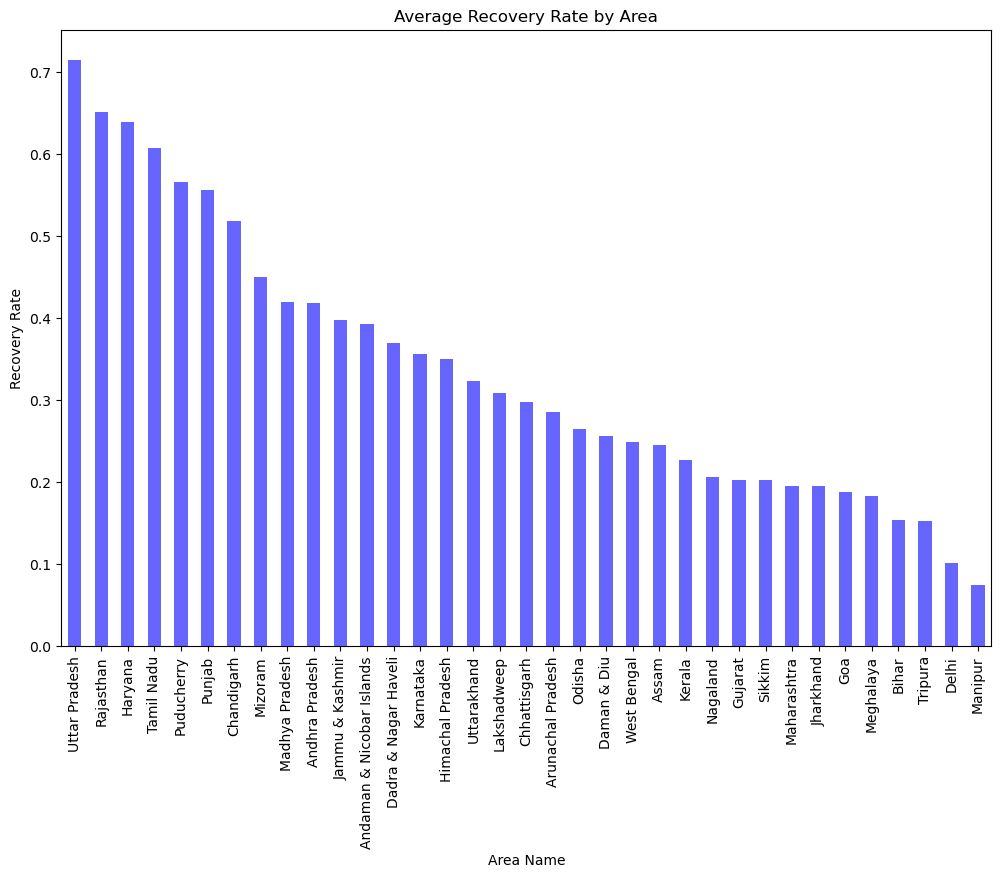

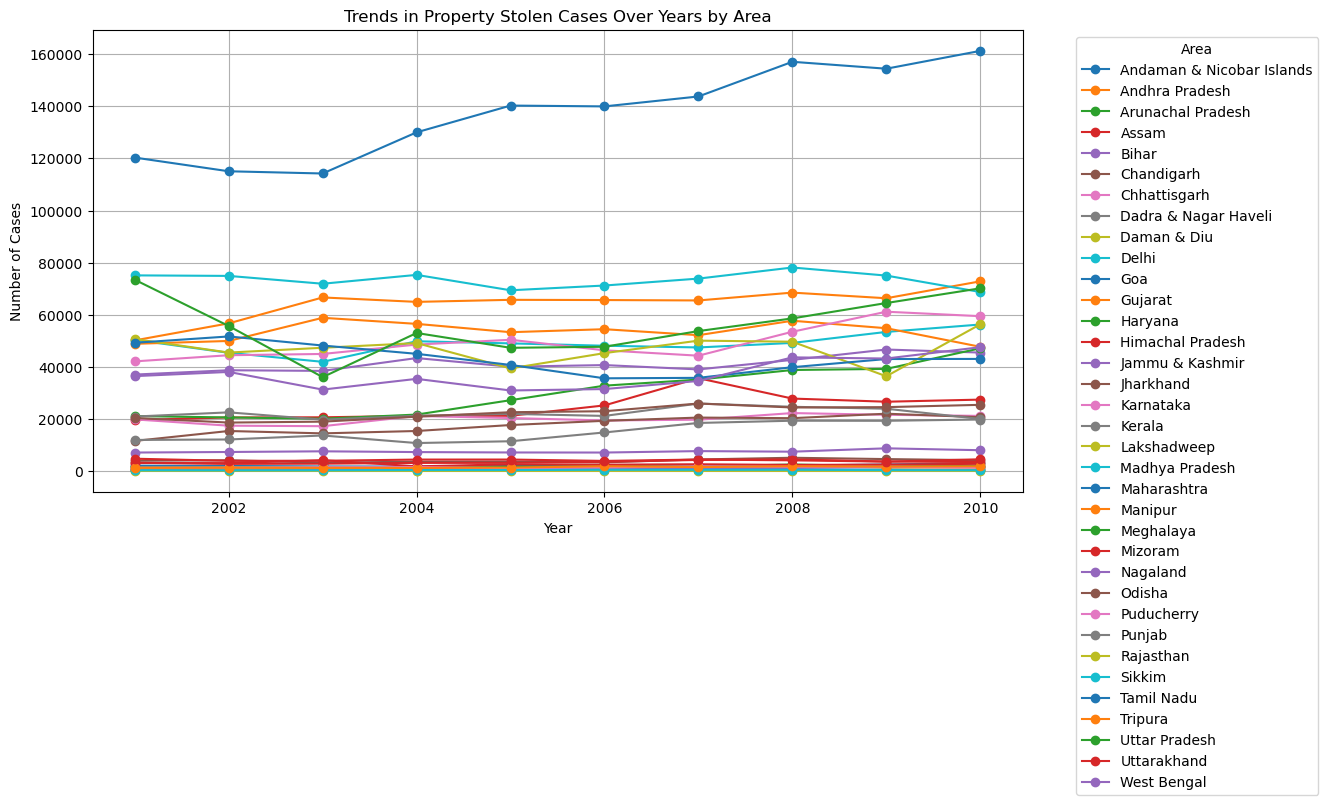

In [14]:
# Annual Summary of Property Stolen vs. Recovered

annual_summary = data.groupby('Year')[['Value_of_Property_Stolen', 'Value_of_Property_Recovered']].sum()

plt.figure(figsize=(10, 6))
annual_summary.plot(kind='bar', color=['red', 'green'], alpha=0.7, ax=plt.gca())
plt.title('Annual Property Stolen vs. Recovered')
plt.xlabel('Year')
plt.ylabel('Value of Property (in Rs)')
plt.legend(['Stolen', 'Recovered'])
plt.grid(True)
plt.show()

# Recovery Rate of Stolen Property Across Different Areas
data['Recovery_Rate'] = data['Value_of_Property_Recovered'] / data['Value_of_Property_Stolen']
area_recovery_rate = data.groupby('Area_Name')['Recovery_Rate'].mean()

plt.figure(figsize=(12, 8))
area_recovery_rate.sort_values(ascending=False).plot(kind='bar', color='blue', alpha=0.6)
plt.title('Average Recovery Rate by Area')
plt.xlabel('Area Name')
plt.ylabel('Recovery Rate')
plt.show()

# Trends in Property Stolen Cases Over Years by Area
plt.figure(figsize=(12, 6))
for area in data['Area_Name'].unique():
    area_data = data[data['Area_Name'] == area]
    yearly_data = area_data.groupby('Year')['Cases_Property_Stolen'].sum()
    plt.plot(yearly_data.index, yearly_data.values, marker='o', label=area)

plt.title('Trends in Property Stolen Cases Over Years by Area')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.legend(title='Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [20]:
# Predictive Analysis Example: Predicting Recovery Rates

# Display column names to verify
print(property_data.columns)

# Update column names if necessary
property_data.rename(columns={
    'Value_of_Property_Recovered': 'Value_Property_Recovered',
    'Value_of_Property_Stolen': 'Value_Property_Stolen'
}, inplace=True)

# Feature Engineering
property_data['Recovery_Rate'] = (property_data['Value_Property_Recovered'] /
                                  property_data['Value_Property_Stolen']) * 100
property_data['Recovery_Rate'] = property_data['Recovery_Rate'].fillna(0)

# Adding additional features
property_data['Recovery_Case_Rate'] = (property_data['Cases_Property_Recovered'] /
                                       property_data['Cases_Property_Stolen']).fillna(0)

# Encode categorical features
le = LabelEncoder()
property_data['Group_Name'] = le.fit_transform(property_data['Group_Name'])
property_data['Sub_Group_Name'] = le.fit_transform(property_data['Sub_Group_Name'])
property_data['Area_Name'] = le.fit_transform(property_data['Area_Name'])

# Features and target
features = ['Year', 'Value_Property_Stolen', 'Recovery_Case_Rate', 'Group_Name', 'Sub_Group_Name']
target = 'Recovery_Rate'

X = property_data[features]
y = property_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"\nMean Squared Error for Recovery Rate Prediction: {mse}")

Index(['Area_Name', 'Year', 'Group_Name', 'Sub_Group_Name',
       'Cases_Property_Recovered', 'Cases_Property_Stolen',
       'Value_Property_Recovered', 'Value_Property_Stolen', 'Recovery_Rate'],
      dtype='object')

Mean Squared Error for Recovery Rate Prediction: 353.01140276685277


In [21]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# Train model with best parameters
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test)
optimized_mse = mean_squared_error(y_test, y_pred_optimized)
print(f"Optimized Mean Squared Error: {optimized_mse}")

Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Best Score: 582.7829935409815
Optimized Mean Squared Error: 336.4993136868799


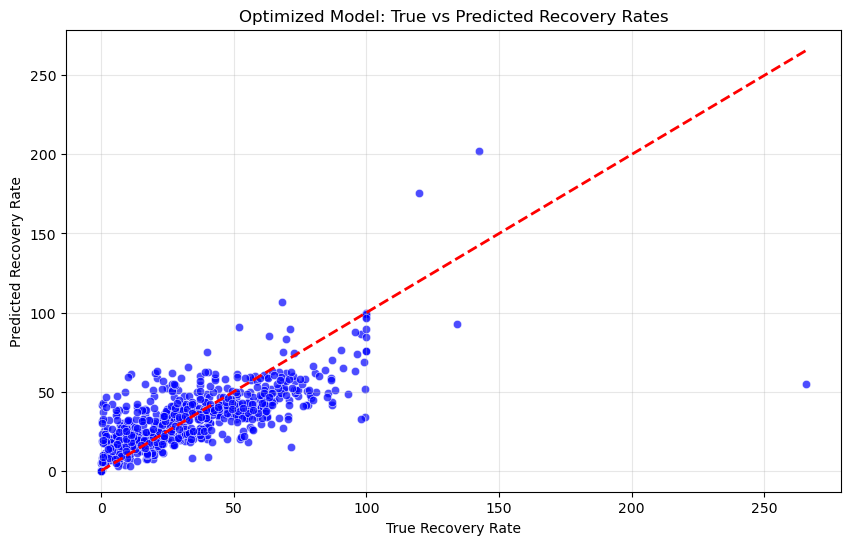

In [22]:
# Compare True vs Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_optimized, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title('Optimized Model: True vs Predicted Recovery Rates')
plt.xlabel('True Recovery Rate')
plt.ylabel('Predicted Recovery Rate')
plt.grid(alpha=0.3)
plt.show()

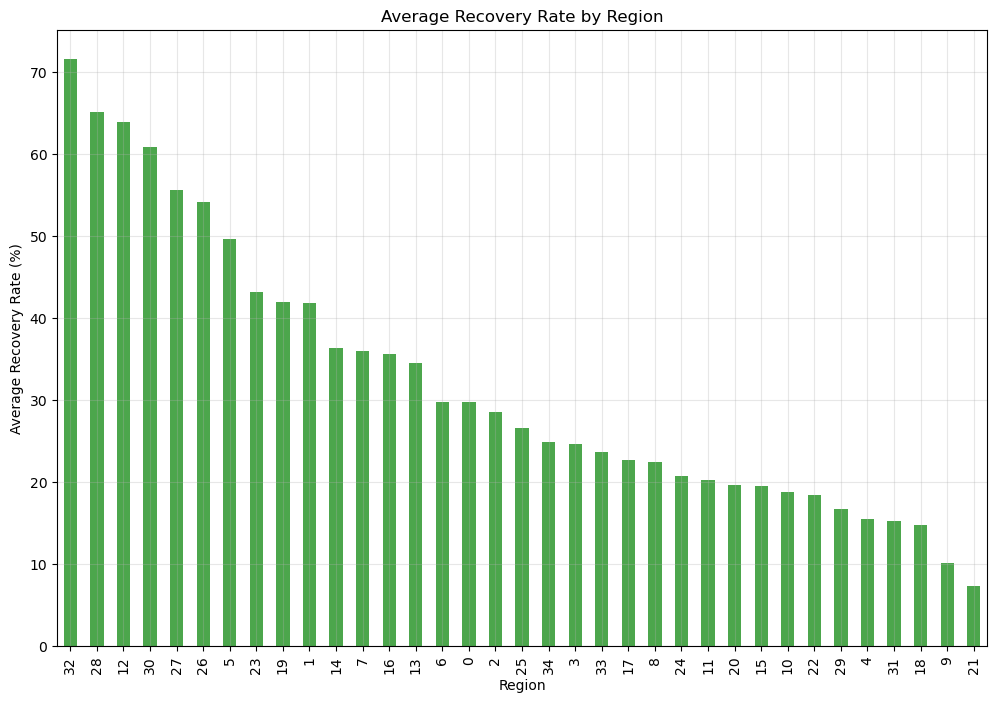

In [23]:
regional_recovery_rate = property_data.groupby('Area_Name')['Recovery_Rate'].mean()

plt.figure(figsize=(12, 8))
regional_recovery_rate.sort_values(ascending=False).plot(kind='bar', color='green', alpha=0.7)
plt.title('Average Recovery Rate by Region')
plt.xlabel('Region')
plt.ylabel('Average Recovery Rate (%)')
plt.grid(alpha=0.3)
plt.show()

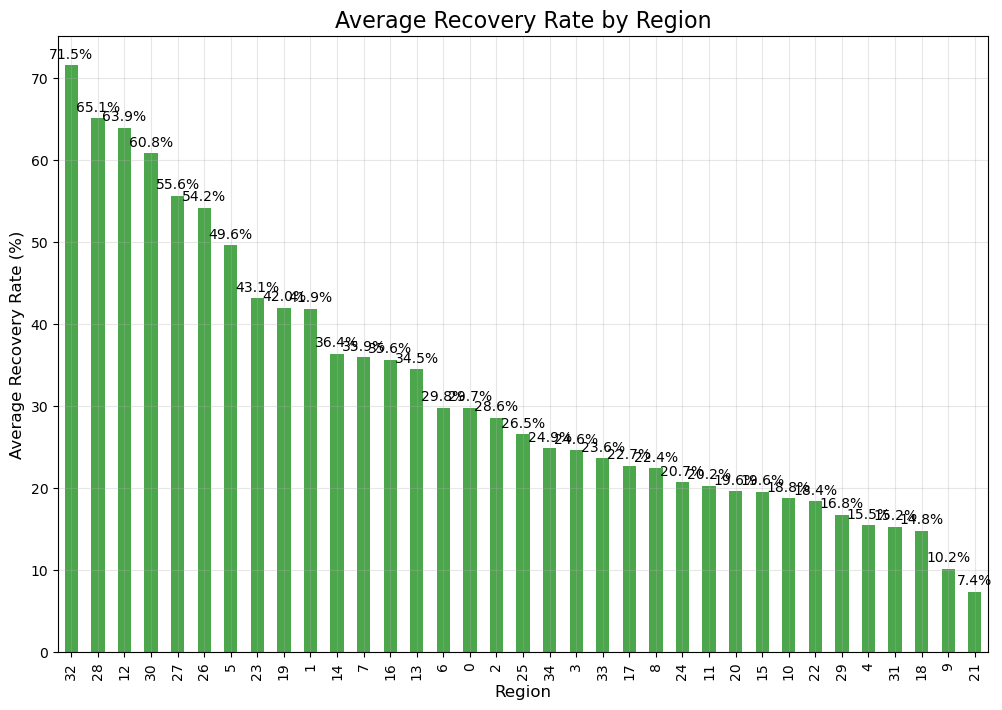

In [24]:
regional_recovery_rate = property_data.groupby('Area_Name')['Recovery_Rate'].mean()

plt.figure(figsize=(12, 8))
ax = regional_recovery_rate.sort_values(ascending=False).plot(kind='bar', color='green', alpha=0.7)
plt.title('Average Recovery Rate by Region', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Recovery Rate (%)', fontsize=12)
plt.grid(alpha=0.3)

# Add annotations for each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()